In [ ]:
# Import files
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model

from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, MaxPool2D, Conv2D, Flatten
from tensorflow.keras.metrics import categorical_crossentropy


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow

from os import listdir
from os.path import isfile, join
import numpy
import cv2

import pandas as pd
import imgaug.augmenters as iaa

# import test, train, and validation folders:
import skimage

In [ ]:
!pip install SimpleITK
import SimpleITK as sitk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install -Uq kaggle
! pip install -Uq fastai==2.2.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.2/191.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 2.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyashukla01","key":"b0652e31cce9e0350fd087c244990d74"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 93% 110M/119M [00:01<00:00, 121MB/s] 
100% 119M/119M [00:01<00:00, 101MB/s]


In [ ]:
! unzip -qq chest-ctscan-images.zip

# Preparing Augmented Dataset

In [ ]:
! mkdir augmented_images

! mkdir augmented_images/train
! mkdir augmented_images/train/cancerous
! mkdir augmented_images/train/non_cancerous

! mkdir augmented_images/test
! mkdir augmented_images/test/cancerous
! mkdir augmented_images/test/non_cancerous

! mkdir augmented_images/validation
! mkdir augmented_images/validation/cancerous
! mkdir augmented_images/validation/non_cancerous

mkdir: cannot create directory ‘augmented_images’: File exists


In [ ]:
# Copy existing images to augmented images folder

# TRAIN IMAGES
! cp -r Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/. augmented_images/train/cancerous/
! cp -r Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/. augmented_images/train/cancerous/
! cp -r Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/. augmented_images/train/cancerous/
! cp -r Data/train/normal/. augmented_images/train/non_cancerous/


# VALIDATION IMAGES
! cp -r Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/. augmented_images/validation/cancerous/
! cp -r Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/. augmented_images/validation/cancerous/
! cp -r Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/. augmented_images/validation/cancerous/
! cp -r Data/valid/normal/. augmented_images/validation/non_cancerous/

# TEST IMAGES
! cp -r Data/test/adenocarcinoma/. augmented_images/test/cancerous/
! cp -r Data/test/large.cell.carcinoma/. augmented_images/test/cancerous/
! cp -r Data/test/squamous.cell.carcinoma/. augmented_images/test/cancerous/
! cp -r Data/test/normal/. augmented_images/test/non_cancerous/

In [ ]:
# Define the data augmentor
augmenter = iaa.Sequential([
    iaa.Crop(px=(0, 25)),                 # crop images from each side by 0 to 25 
    iaa.Flipud(0.5),                      # vertically flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0))      # apply gaussian blur with a sigma of 0 to 3.0
])

In [ ]:
dirpaths = ["augmented_images/test", "augmented_images/train", "augmented_images/validation"]

for dirpath in dirpaths:
  images = []
  canc_path = dirpath + "/cancerous"
  non_canc_path = dirpath + "/non_cancerous"

  # For cancerous images
  for img_path in os.listdir(canc_path):
    image_ = cv2.imread(canc_path +'/'+img_path)
    images.append(image_)

  count = 0
  for i in range(len(images)):
      image = images[i]
      augmented_image = augmenter.augment_image(image)
      cv2.imwrite(f"{canc_path}/augmented-{i}.jpg",augmented_image)
      count +=1
      k = cv2.waitKey(1000)

  print(f"Train Images in {canc_path} = {count}")
  
  # For non cancerous images
  images = []
  for img_path in os.listdir(non_canc_path):
    image_ = cv2.imread(non_canc_path +'/'+img_path)
    images.append(image_)

  count = 0
  for i in range(len(images)):
      image = images[i]
      augmented_image = augmenter.augment_image(image)
      cv2.imwrite(f"{non_canc_path}/augmented-{i}.jpg",augmented_image)
      count +=1
      k = cv2.waitKey(1000)

  print(f"Train Images in {non_canc_path} = {count}")

Train Images in augmented_images/test/cancerous = 224
Train Images in augmented_images/test/non_cancerous = 54
Train Images in augmented_images/train/cancerous = 418
Train Images in augmented_images/train/non_cancerous = 148
Train Images in augmented_images/validation/cancerous = 50
Train Images in augmented_images/validation/non_cancerous = 13


# Implementing ResNet50 model

In [ ]:
train_path = "augmented_images/train"
valid_path = "augmented_images/validation"
test_path = "augmented_images/test"

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 2
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32')#, preprocessing_function=resnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32')#, preprocessing_function=resnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32')#, preprocessing_function=resnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 1132 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Found 556 images belonging to 2 classes.


In [ ]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model = Sequential()
model.add(res_model)
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(N_CLASSES, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                        

In [ ]:
optimizer = Adam(learning_rate= 0.00001, decay=0.0005)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='/content/gdrive/My Drive/SML_Project/chest_CT_SCAN-ResNet50_augmented.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=20)

In [ ]:
history_res = model.fit(train_generator,
                    steps_per_epoch = 10,
                    epochs = 10,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.0727 - acc: 0.5938 
Epoch 1: val_loss improved from inf to 0.43641, saving model to /content/gdrive/My Drive/SML_Project/chest_CT_SCAN-ResNet50_augmented.hdf5
10/10 [==============================] - 594s 60s/step - loss: 1.0727 - acc: 0.5938 - val_loss: 0.4364 - val_acc: 0.8254
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6884 - acc: 0.7406 
Epoch 2: val_loss improved from 0.43641 to 0.32407, saving model to /content/gdrive/My Drive/SML_Project/chest_CT_SCAN-ResNet50_augmented.hdf5
10/10 [==============================] - 591s 61s/step - loss: 0.6884 - acc: 0.7406 - val_loss: 0.3241 - val_acc: 0.8651
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.5087 - acc: 0.7781 
Epoch 3: val_loss improved from 0.32407 to 0.23966, saving model to /content/gdrive/My Drive/SML_Project/chest_CT_SCAN-ResNet50_augmented.hdf5
10/10 [==============================] - 592s 61s/step - loss: 

In [ ]:
result = model.evaluate(test_generator)

18/18 [==============================] - 542s 30s/step - loss: 0.1429 - acc: 0.9964


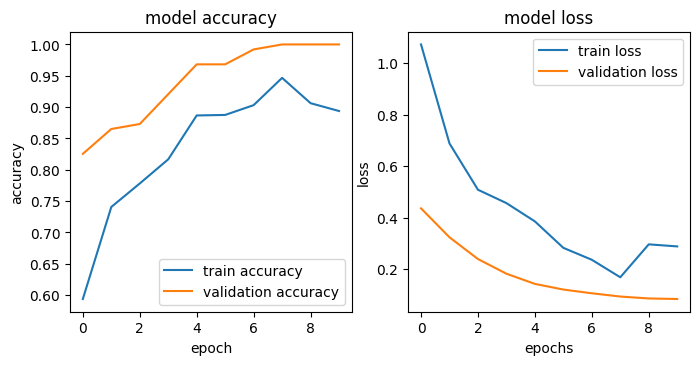

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.plot(history_res.history['acc'])
plt.plot(history_res.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy','validation accuracy'])

plt.subplot(222)
plt.plot(history_res.history['loss'])
plt.plot(history_res.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'])

plt.show()

### Serialize model

In [ ]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/SML_Project/model_resnet50_augmented.json","w") as json_file:
  json_file.write(model_json)

# Implementing Lime

In [ ]:
! pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=e593a2f7adf65d88cdcd645fbcaa133b92af1513627ea15f5f02a724ef62e4e6
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
from keras.models import model_from_json
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

np.random.seed(123)

In [ ]:
IMG_SIZE = (460, 460)
def transform_image(img):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

# # path = "/content/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000021.png"
# path = "/content/Data/test/adenocarcinoma/000122.png"
# img = image.load_img(path, target_size=IMG_SIZE)

# normalized_img = transform_image(img)

In [ ]:
test_generator.class_indices

{'cancerous': 0, 'non_cancerous': 1}

In [ ]:
def get_model_predictions(data):
    model_prediction = model.predict(data)
    if model_prediction[0][0] > model_prediction[0][1] :
      print(f"The predicted class is : cancerous with probability - {model_prediction[0][0]}")
    else :
      print(f"The predicted class is : non cancerous with probability - {model_prediction[0][1]}")
    # return decode_predictions(model_prediction, top=1)[0][0][1]

In [ ]:
from skimage.segmentation import mark_boundaries

def masked_explaind_images(exp) :
  temp_1, mask_1 = exp.get_image_and_mask(exp.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
  temp_2, mask_2 = exp.get_image_and_mask(exp.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
  ax1.imshow(mark_boundaries(temp_1, mask_1))
  ax2.imshow(mark_boundaries(temp_2, mask_2))
  ax1.axis('off')
  ax2.axis('off')

In [ ]:
explainer = lime_image.LimeImageExplainer()
def lime(path):
  img = image.load_img(path, target_size=IMG_SIZE)
  normalized_img = transform_image(img)

  plt.imshow(normalized_img[0])
  # pred_orig = get_model_predictions(normalized_img) 

  exp = explainer.explain_instance(normalized_img[0], 
                                  model.predict)
  masked_explaind_images(exp)



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


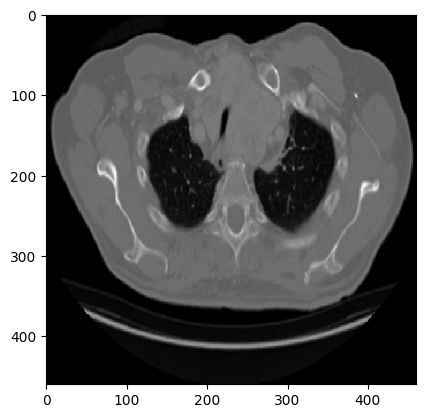

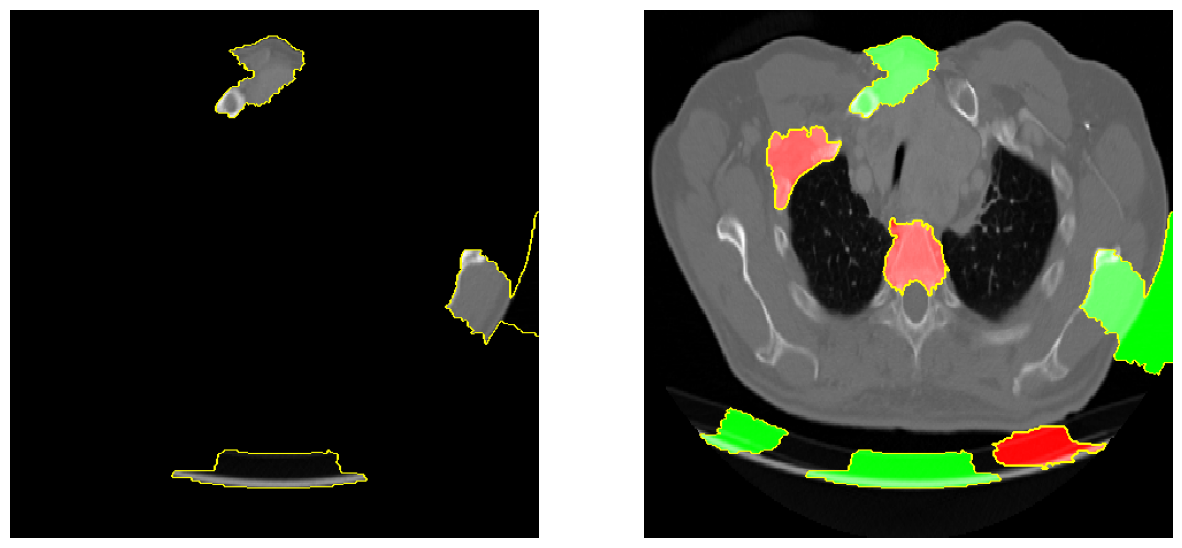

In [ ]:
image_paths = ["/content/augmented_images/test/cancerous/000108.png", "/content/augmented_images/test/non_cancerous/21.png"]

lime(image_paths[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


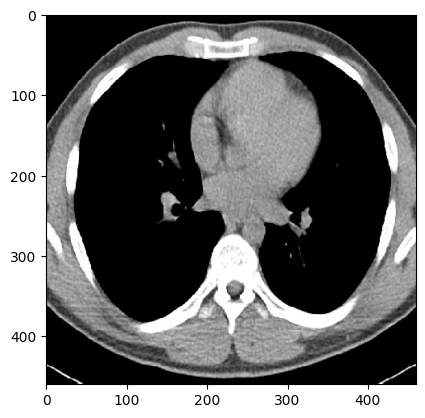

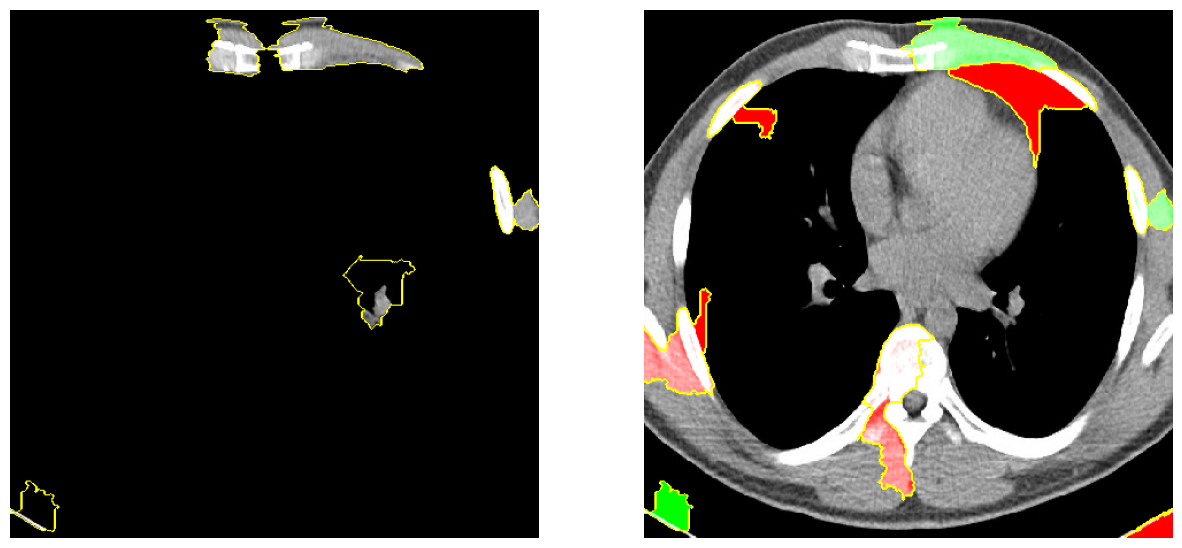

In [ ]:
lime(image_paths[1])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


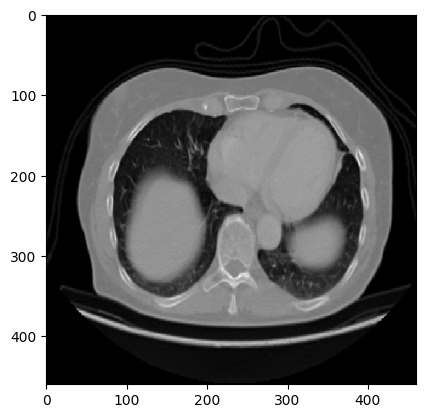

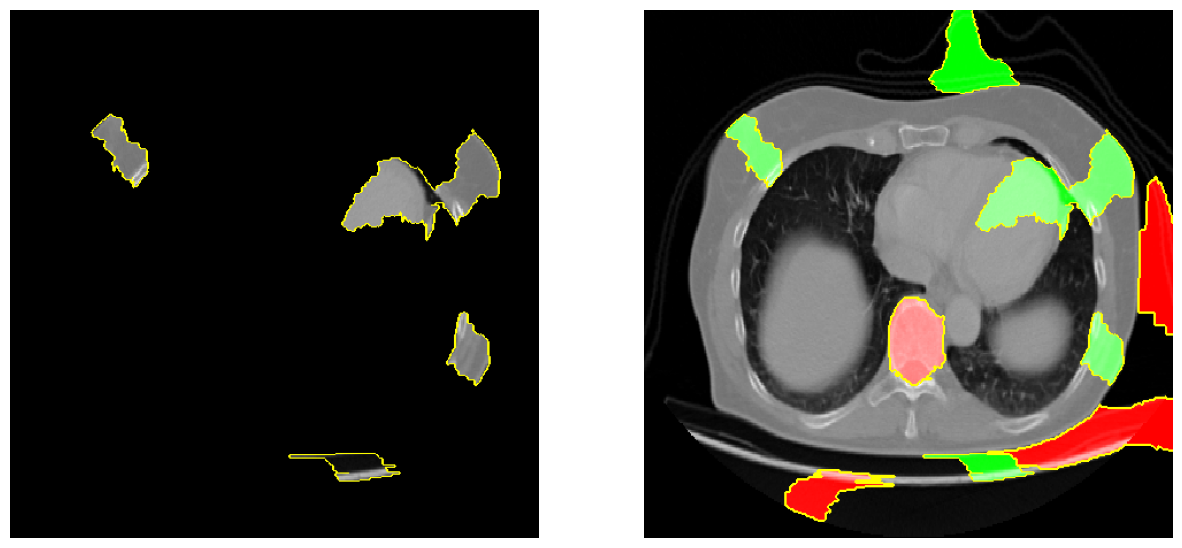

In [ ]:
lime("/content/augmented_images/test/cancerous/000113.png")